In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import f1_score, r2_score


def get_fast_dataset(e2_npy, srs_npy, batch_size=4, e2_len=20, srs_input_rows=100, pred_offset=50):
    # Load the binary data
    e2_data = np.load(e2_npy)
    srs_data = np.load(srs_npy)

    # Calculate valid steps
    num_steps_srs = (len(srs_data) - (srs_input_rows + pred_offset)) // 50
    num_steps_e2 = len(e2_data) - e2_len
    num_steps = min(num_steps_e2, num_steps_srs)

    def data_generator():
        for t in range(num_steps):
            # E2 Processing
            e2_chunk = e2_data[t : t + e2_len]
            # Fast flatten and reshape
            X_e2 = np.zeros(380, dtype=np.float32)
            X_e2[:e2_chunk.size] = e2_chunk.flatten()[:380]
            X_e2 = X_e2.reshape(5, 4, 19)

            # SRS Processing (Jumping by 50)
            srs_start = t * 50
            X_srs = srs_data[srs_start : srs_start + srs_input_rows].reshape(20, 20, 1536)

            # Label
            y = srs_data[srs_start + srs_input_rows + pred_offset - 1]
            
            yield (X_e2, X_srs), y

    output_signature = (
        (tf.TensorSpec(shape=(5, 4, 19), dtype=tf.float32), 
         tf.TensorSpec(shape=(20, 20, 1536), dtype=tf.float32)),
        tf.TensorSpec(shape=(4, 1536), dtype=tf.float32)
    )

    ds = tf.data.Dataset.from_generator(data_generator, output_signature=output_signature)

    return ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)



In [10]:
def create_model(e2_input_shape=(5, 4, 19), srs_input_shape=(20, 20, 1536), lstm_units=128, dropout_rate=0.3):
    # Radio Branch
    radio_input = layers.Input(shape=e2_input_shape, name='radio_input')
    r1 = layers.Conv2D(32, (3, 3), padding='same')(radio_input)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.Activation('relu')(r1)
    r1 = layers.ZeroPadding2D(padding=((0,0),(0,1)))(r1) # Result: (5, 5, 32)
    r1 = layers.Conv2D(64, (3, 3), padding='same')(r1)
    r1 = layers.BatchNormalization()(r1) # (5, 5, 64)
    r1 = layers.Activation('relu')(r1)

    # SRS Branch
    srs_input = layers.Input(shape=srs_input_shape, name='srs_input')
    s1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(srs_input) # Reduced filters for speed
    s1_shortcut = s1 # (20, 20, 512)

    s1 = layers.Conv2D(128, (1, 1), padding='valid')(s1)
    s1 = layers.BatchNormalization()(s1) # (20, 20, 128)
    s1 = layers.Activation('relu')(s1)
    s1 = layers.Conv2D(128, (3, 3), padding='same')(s1)
    s1 = layers.BatchNormalization()(s1) # (20, 20, 128)
    s1 = layers.Activation('relu')(s1)
    s1 = layers.Conv2D(256, (1, 1), padding='valid')(s1)
    s1 = layers.BatchNormalization()(s1) # (20, 20, 256)

    s1_shortcut = layers.Conv2D(256, (1, 1), activation='relu', padding='valid')(s1_shortcut)
    s1_shortcut = layers.BatchNormalization()(s1_shortcut) # (20, 20, 256)

    s1 = layers.Add()([s1, s1_shortcut]) # (20, 20, 256)
    s1 = layers.Activation('relu')(s1)

    s1_shortcut = s1 # (20, 20, 256)
    s1 = layers.Conv2D(256, (1, 1), padding='valid')(s1) 
    s1 = layers.BatchNormalization()(s1) # (20, 20, 256)
    s1 = layers.Activation('relu')(s1)
    s1 = layers.Conv2D(256, (3, 3), padding='same')(s1)
    s1 = layers.BatchNormalization()(s1) # (20, 20, 256)
    s1 = layers.Activation('relu')(s1)
    s1 = layers.Conv2D(512, (1, 1), padding='valid')(s1)
    s1 = layers.BatchNormalization()(s1) # (20, 20, 512)

    s1_shortcut = layers.Conv2D(512, (1, 1), activation='relu', padding='valid')(s1_shortcut)
    s1_shortcut = layers.BatchNormalization()(s1_shortcut) # (20, 20, 512)

    s1 = layers.Add()([s1, s1_shortcut])
    s1 = layers.Activation('relu')(s1)

    s1 = layers.AveragePooling2D((2, 2))(s1) # (10, 10, 512)
    s1 = layers.AveragePooling2D((2, 2))(s1) # (5, 5, 512)
    s1 = layers.BatchNormalization()(s1)

    # Concatenate
    x = layers.Concatenate(axis=-1)([r1, s1]) #   (5, 5, 576)
    x = layers.Reshape((25, 576))(x)
    x = layers.LSTM(lstm_units, return_sequences=True)(x)
    x = layers.Flatten()(x) 
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dense(4 * 1536, activation='linear')(x)
    output = layers.Reshape((4, 1536))(x)

    model = models.Model(inputs=[radio_input, srs_input], outputs=output)
    model.compile(optimizer='adam', loss='log_cosh', metrics=['mse'])
    return model

In [11]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 srs_input (InputLayer)         [(None, 20, 20, 153  0           []                               
                                6)]                                                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 20, 20, 512)  7078400     ['srs_input[0][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 20, 20, 128)  65664       ['conv2d_13[0][0]']              
                                                                                                  
 batch_normalization_13 (BatchN  (None, 20, 20, 128)  512        ['conv2d_14[0][0]']        

Epoch 1/100
47/47 [==============================] - 6s 69ms/step - loss: 41.1173 - mse: 4520.1348
Epoch 2/100
47/47 [==============================] - 3s 68ms/step - loss: 41.1113 - mse: 4518.4795
Epoch 3/100
47/47 [==============================] - 3s 68ms/step - loss: 41.1042 - mse: 4516.5654
Epoch 4/100
47/47 [==============================] - 3s 68ms/step - loss: 41.0985 - mse: 4516.4292
Epoch 5/100
47/47 [==============================] - 3s 68ms/step - loss: 41.0793 - mse: 4511.6924
Epoch 6/100
47/47 [==============================] - 3s 67ms/step - loss: 41.0197 - mse: 4499.9795
Epoch 7/100
47/47 [==============================] - 3s 68ms/step - loss: 41.0572 - mse: 4507.4180
Epoch 8/100
47/47 [==============================] - 3s 67ms/step - loss: 40.9129 - mse: 4481.8198
Epoch 9/100
47/47 [==============================] - 3s 68ms/step - loss: 40.6951 - mse: 4449.9072
Epoch 10/100
47/47 [==============================] - 3s 68ms/step - loss: 40.4270 - mse: 4391.5464
Epoch 11/

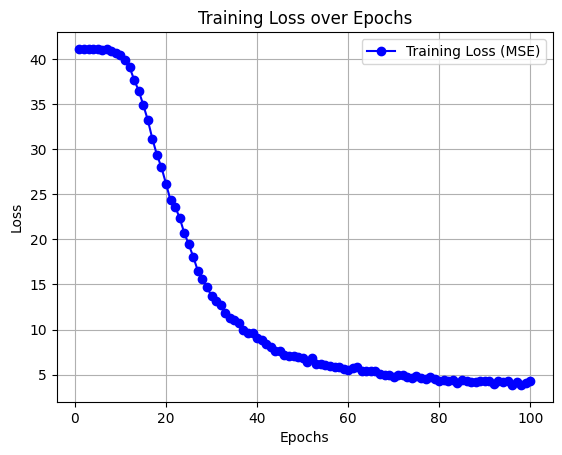

In [12]:
train_ds = get_fast_dataset("train_e2.npy", "train_srs.npy", batch_size=8) # Increased batch size

history = model.fit(train_ds, epochs=100)

loss = history.history['loss']
epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo-', label='Training Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show() 

In [13]:

test_e2_npy = "P:/SP Challenge/Model/train_e2.npy"
test_srs_npy = "P:/SP Challenge/Model/train_srs.npy"
THRESHOLD = 0.5 


test_ds = get_fast_dataset(test_e2_npy, test_srs_npy, batch_size=1)

# 1. Official Keras Evaluation (MSE)
test_ds = get_fast_dataset(
    test_e2_npy,
    test_srs_npy,
    batch_size=8
)

results = model.evaluate(test_ds, return_dict=True)

print("Test Loss:", results['loss'])
print("Test MSE :", results['mse'])


47/47 [==============================] - 2s 37ms/step - loss: 37.5594 - mse: 3305.8083
Test Loss: 37.559383392333984
Test MSE : 3305.808349609375
